### Loading the entire dataset, Scaling data points and splitting data
##### Including removing the inf and nan values in the dataset with the median values of their respective feature columns


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

df = pd.read_csv("CICIDS2017_Wednesday_Paper.csv")
df.columns=df.columns.str.strip()
df = df[df['Label'] != 'Heartbleed']

#Replacing the 4 'nan' values in the 'Flow Bytes/s' feature with the median of all values
df["Flow Bytes/s"].replace(np.nan, np.median(df["Flow Bytes/s"].dropna()),inplace=True)
#There are 30 and 34 inifinite values in the 'Flow Bytes/s' and ' Flow Packets/s', respectively.
df.replace(np.inf,np.nan,inplace=True) #We first change inf values to nan values since I find them easier to delete
df["Flow Bytes/s"].replace(np.nan, np.max(df["Flow Bytes/s"].dropna()) ,inplace=True) #Then we are changing them with the max value in the column
df["Flow Packets/s"].replace(np.nan, np.max(df["Flow Packets/s"].dropna()) ,inplace=True)
df.replace(["BENIGN","DoS Hulk","DoS GoldenEye","DoS slowloris","DoS Slowhttptest"],[0,1,2,3,4],inplace=True)

X = MinMaxScaler().fit_transform(df.drop(['Label'],axis=1))
y=df["Label"]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=42)

C:\Users\dyari\AppData\Local\Temp\ipykernel_14840\3885227182.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Flow Bytes/s"].replace(np.nan, np.median(df["Flow Bytes/s"].dropna()),inplace=True)
C:\Users\dyari\AppData\Local\Temp\ipykernel_14840\3885227182.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

### Training the MLP model

In [5]:
from sklearn.neural_network import MLPClassifier
import time

clf = MLPClassifier(hidden_layer_sizes=(100,200,250),
                    max_iter=50,solver="adam",
                    verbose=True,activation='relu',
                    learning_rate_init=0.01,random_state=42)

start_time = time.time()
# Fit data onto the model
clf.fit(X_train,y_train)

end_time = time.time()
elapsed_time = end_time - start_time

Iteration 1, loss = 0.04421620
Iteration 2, loss = 0.02156663
Iteration 3, loss = 0.02063403
Iteration 4, loss = 0.01862878
Iteration 5, loss = 0.01930465
Iteration 6, loss = 0.01941927
Iteration 7, loss = 0.01722494
Iteration 8, loss = 0.01778765
Iteration 9, loss = 0.01772709
Iteration 10, loss = 0.01732619
Iteration 11, loss = 0.01661284
Iteration 12, loss = 0.01630773
Iteration 13, loss = 0.01711614
Iteration 14, loss = 0.01709652
Iteration 15, loss = 0.01820865
Iteration 16, loss = 0.01668280
Iteration 17, loss = 0.01619856
Iteration 18, loss = 0.01692957
Iteration 19, loss = 0.01678088
Iteration 20, loss = 0.01646431
Iteration 21, loss = 0.01619958
Iteration 22, loss = 0.01666270
Iteration 23, loss = 0.01577757
Iteration 24, loss = 0.01616354
Iteration 25, loss = 0.01608030
Iteration 26, loss = 0.01590698
Iteration 27, loss = 0.01617691
Iteration 28, loss = 0.01650507
Iteration 29, loss = 0.01618697
Iteration 30, loss = 0.01594398
Iteration 31, loss = 0.01619354
Iteration 32, los

### Predictions BEFORE sample modification

Accuracy: 0.9967373808097358
---------------------------------------------------------


array([[87677,   327,    21,    13,    33],
       [   11, 46207,     0,     0,     0],
       [    1,    10,  2033,     0,     2],
       [    3,     1,     0,  1094,    16],
       [    8,     0,     0,     6,  1076]], dtype=int64)

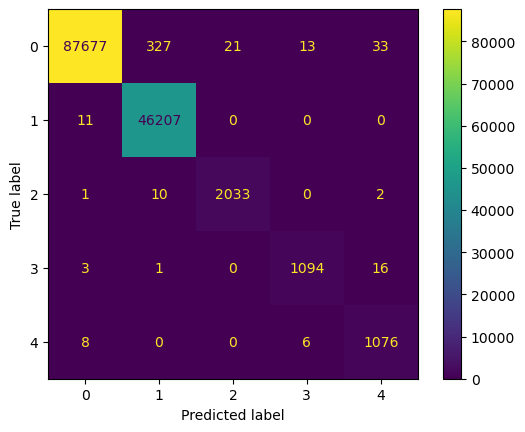

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,f1_score,recall_score

y_pred=clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test,y_pred))
print("---------------------------------------------------------")

BeforePerturbation = ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
BeforePerturbation.confusion_matrix

### Sample modification - Both Benign and Malicious Shuffle

In [9]:
import random

#Identify the unique 'Flow IAT Mean' values of all classes
unique_values = df['Flow IAT Mean'].unique()

random.seed(42)

def SystematicShuffling(X, y, feature='Flow IAT Mean'):
    # Ensure X and y are pandas DataFrames and Series
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X, columns=df.drop(columns=['Label']).columns)
    if isinstance(y, np.ndarray):
        y = pd.Series(y)

    X_copy = X.copy()
    y_copy = y.copy()

    # Loop through the dataset
    for idx in range(len(X)):
        X_copy.loc[idx, feature] = random.choice(unique_values)

    return X_copy, y_copy


X_evasive3, y_evasive3 = SystematicShuffling(X_test, y_test, feature='Flow IAT Mean')

### Predictions After sample modification 03 - Both Benign and Malicious Shuffle

C:\Users\dyari\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


Accuracy: 0.6357848692425959


array([[88068,     0,     3,     0,     0],
       [46202,    12,     4,     0,     0],
       [ 2045,     0,     1,     0,     0],
       [ 1113,     0,     1,     0,     0],
       [ 1090,     0,     0,     0,     0]], dtype=int64)

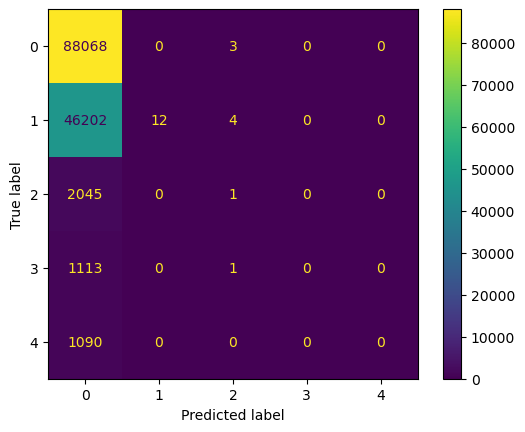

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,f1_score,recall_score

y_pred3_evasive = clf.predict(X_evasive3)
print("Accuracy:", accuracy_score(y_evasive3,y_pred3_evasive))

Perturb03=ConfusionMatrixDisplay.from_predictions(y_evasive3, y_pred3_evasive)
Perturb03.confusion_matrix